In [7]:
!pip install pycm livelossplot torchvision
%pylab inline

     |████████████████████████████████| 438 kB 8.6 MB/s eta 0:00:01
Populating the interactive namespace from numpy and matplotlib


/Users/navjot/miniconda3/envs/devito/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# ACSE Module 8 - Practical - Morning Session 3:
----
# Training Deep Neural Networks - Crossvalidation

In this exercise you will use cross-validation to estimate the hyperparameters of a deep-neural network trained on the MNIST dataset and create predictions on the MNIST datasets public test set.

#### A few imports before we get started

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


### Mounting the google drive for later storage

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

ModuleNotFoundError: No module named 'google'

### The MNIST Dataset - Hello World of Deep-Learning

In [3]:
mnist_train = MNIST("./", download=True, train=True)
mnist_test = MNIST("./", download=True, train=False)

0.0%

100.1%

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


28.4%

0.5%5%

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


100.4%

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


180.4%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


### Instantiate and create a ```StratifiedShuffleSplit``` using sklearn.
1. Create a ```sklearn.model_selection.StratifiedShuffleSplit``` object with 1-split and a test-size of 10%.
2. Get the training and validation indices from the shuffel-split 

In [4]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.train_data, mnist_train.train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

/Users/navjot/miniconda3/envs/devito/lib/python3.8/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/navjot/miniconda3/envs/devito/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


### Splitting and normalize the data
The original mnist data is given in gray-scale values between 0 and 255.
You will need to write a normalisation method that takes in a ```torch.Tensor``` and performs normalisation.
The mean of MNIST is 0.1307 and it's standard deviation is 0.3081 (after division by 255).

Finally, torch likes all categorical data to be in a ```.long()``` format.
Therefore


In [5]:
def apply_normalization(X):
  X /= 255.
  X -= 0.1307
  X /= 0.3081
  return X

In [6]:
X_train, y_train = apply_normalization(mnist_train.train_data[indices[0]].float()), mnist_train.train_labels[indices[0]]
X_val, y_val = apply_normalization(mnist_train.train_data[indices[1]].float()), mnist_train.train_labels[indices[1]]
X_test, y_test =  apply_normalization(mnist_test.test_data.float()), mnist_test.test_labels

/Users/navjot/miniconda3/envs/devito/lib/python3.8/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/navjot/miniconda3/envs/devito/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/navjot/miniconda3/envs/devito/lib/python3.8/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/navjot/miniconda3/envs/devito/lib/python3.8/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Instantiate a ```torch.utils.data.TensorDataset``` for training, validation and test data

In [7]:
mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

Let's visualise an example of the images and check whether the data is normalised properly (compute .mean() and .std() on the training set.)

tensor(9.8159e-05) tensor(1.0003)


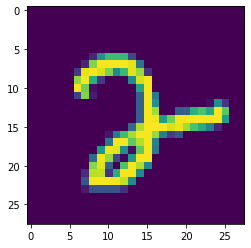

In [10]:
import matplotlib.pyplot as plt


plt.imshow(X_train[0])
print(X_train.mean(), X_train.std())

### Create a SimpleNet as a ```nn.Module```
Create a simple feed-forward neural network with the following architecture:
- Input Layer: 28*28 neurons
- Hidden Layer: 25 neurons
- Output Layer: 10 neurons
- Hidden Layer Activation: ReLU
- Output Layer Activation: None


In [11]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.linear_1 = nn.Linear(28*28, 25)
        self.linear_2 = nn.Linear(25, 10)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        z1 = self.linear_1(x)
        a1 = self.activation(z1)
        z2 = self.linear_2(a1)
        return z2

### Sanity checks on our SimpleNet


In [12]:
model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()

X_ = X_train[0].view(-1, 28*28).to(device)
y_ = torch.zeros((1)).to(device).long()

a2 = model(X_)
loss = criterion(a2, y_)

y_pred = F.log_softmax(a2, dim=1).max(1)[1]

print(F.log_softmax(a2, dim=1))
print(y_pred)

tensor([[-2.3947, -2.3068, -2.0824, -2.6213, -2.3801, -2.5030, -2.4592, -2.1880,
         -1.9526, -2.3234]], grad_fn=<LogSoftmaxBackward>)
tensor([8])


### Create simple train function

The function should perform the following tasks:
1. Set the model into training mode
2. Iterate over all the mini-batches
3. Send the batches to the GPU / CPU
4. Zero all the gradients
5. Perform the forward-pass
6. Compute the loss
7. Perform the backward-pass
8. Keep a running measure of training loss and accuracy
9. Perform a step of gradient-descent
10. Once done with all batches, return average training loss and accuracy

In [13]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 28*28))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

### Create simple validate function

The function should perform the following tasks:
1. Set the model into evaluation mode
2. Iterate over all the mini-batches
3. Send the batches to the GPU / CPU
5. Perform the forward-pass
6. Compute the loss
8. Keep a running measure of validation loss and accuracy
10. Once done with all batches, return average validation loss and accuracy

In [14]:
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 28*28))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

 ### Set the hyperparameters of your model
- Seed: 42
- learning rate: 1e-2
- Optimizer: SGD
- momentum: 0.9
- Number of Epochs: 30
- Batchsize: 64
- Test Batch Size (no effect on training apart from time): 1000
- Shuffle the training set every epoch: Yes

In [15]:
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 30

### Instantiate our model, optimizer and loss function
Set the random number generator seed using ```set_seed``` to make everything reproducible.
As a criterion use a sensible loss for the multi-class classification problem.

In [19]:
set_seed(seed)
model = SimpleNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

### Create dataloaders for the training, validation and test data

In [20]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

### Perform the training of the network and validation
Here we provide you with a method to visualize both training and validation loss while training your networks.

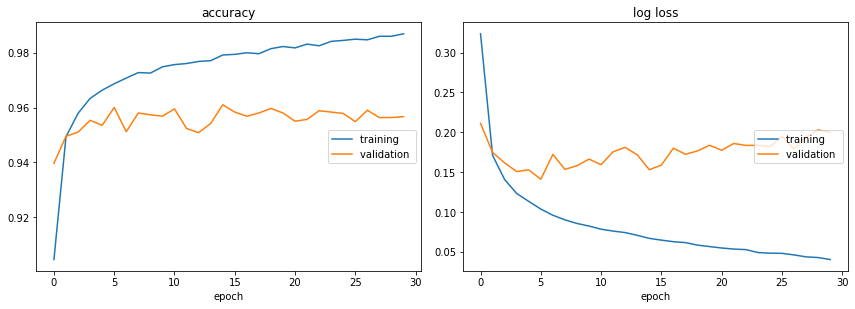

accuracy
	training         	 (min:    0.905, max:    0.987, cur:    0.987)
	validation       	 (min:    0.940, max:    0.961, cur:    0.957)
log loss
	training         	 (min:    0.040, max:    0.324, cur:    0.040)
	validation       	 (min:    0.141, max:    0.211, cur:    0.200)


In [21]:
liveloss = PlotLosses()
for epoch in range(30):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()

It seems the model isn't doing very well. Maybe we can do better.
Run a grid search over the momentum value, use the following: momentum = [0.1, 0.5, 0.9]
and run the model on the full training set with the best value for the momentum parameter.

In [22]:
def train_model(momentum):
  set_seed(seed)
  model = SimpleNet().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
  test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return True

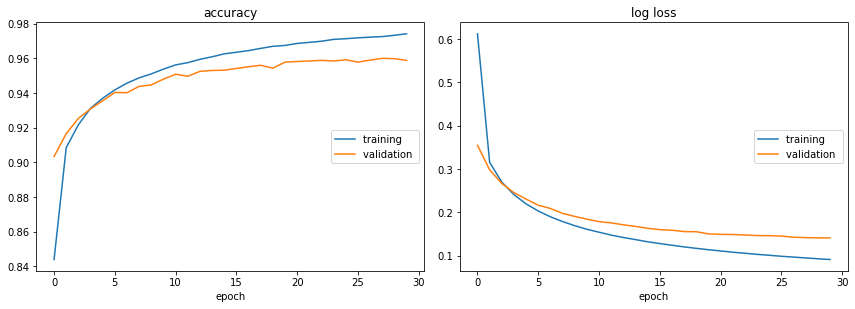

accuracy
	training         	 (min:    0.844, max:    0.987, cur:    0.974)
	validation       	 (min:    0.903, max:    0.961, cur:    0.959)
log loss
	training         	 (min:    0.040, max:    0.613, cur:    0.091)
	validation       	 (min:    0.141, max:    0.355, cur:    0.141)


True

In [23]:
train_model(0.1)

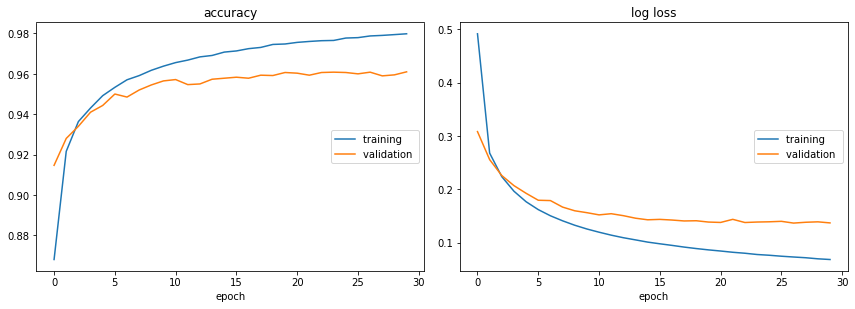

accuracy
	training         	 (min:    0.844, max:    0.987, cur:    0.980)
	validation       	 (min:    0.903, max:    0.961, cur:    0.961)
log loss
	training         	 (min:    0.040, max:    0.613, cur:    0.069)
	validation       	 (min:    0.137, max:    0.355, cur:    0.137)


True

In [24]:
train_model(0.5)

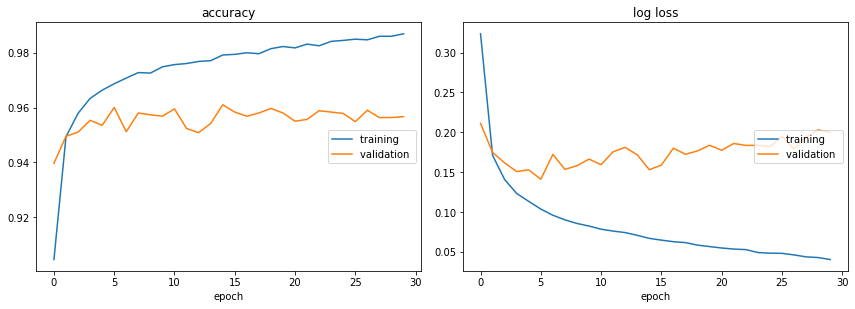

accuracy
	training         	 (min:    0.844, max:    0.987, cur:    0.987)
	validation       	 (min:    0.903, max:    0.961, cur:    0.957)
log loss
	training         	 (min:    0.040, max:    0.613, cur:    0.040)
	validation       	 (min:    0.137, max:    0.355, cur:    0.200)


True

In [25]:
train_model(0.9)

In [29]:
best_momentum = 0.5

### Implement an evaluate method
This method performs the same as validate but doesn't report losses, but simply returns all predictions on a given dataset (training, validation, test-set)

In [28]:
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 28*28))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

y_pred, y_gt = evaluate(model, validation_loader)

### Plotting a confusion matrix

We can use a confusion matrix to diagnose problems in our models.
We may see for example that our model confuses 9's for 4's quite often.

In [29]:
cm = ConfusionMatrix(actual_vector=y_gt, predict_vector=y_pred) # Create CM From Data
print(cm)

Predict   0         1         2         3         4         5         6         7         8         9         
Actual
0         585       1         1         0         0         1         1         0         2         1         

1         0         666       2         2         0         0         0         0         2         2         

2         1         10        569       2         1         0         3         6         3         1         

3         3         2         6         578       0         13        0         2         6         3         

4         1         2         7         0         561       1         1         1         2         8         

5         1         0         0         7         2         521       3         0         6         2         

6         8         0         1         0         8         2         569       1         3         0         

7         2         5         6         3         3         2         0         595       1       

/Users/navjot/miniconda3/envs/devito/lib/python3.8/site-packages/pycm/pycm_obj.py:192: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


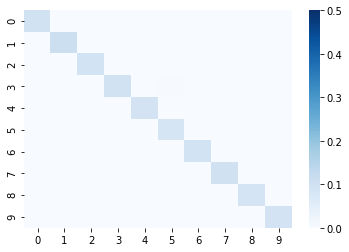

In [37]:
import seaborn as sns


def to_raw_matrix(cm):
    plt_cm = []
    for i in cm.classes :
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    return plt_cm

rcm = to_raw_matrix(cm)
rcm = rcm/np.sum(rcm)


sns.heatmap(rcm, cmap="Blues", vmax=0.5)

### Given that you estimated your hyperparameters, train your model on the full dataset and evaluate on the test set

In [31]:
mnist_train = MNIST("./", download=True, train=True)

X_train, y_train = apply_normalization(mnist_train.train_data.float()), mnist_train.train_labels
mnist_train = TensorDataset(X_train, y_train)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

set_seed(seed)
model = SimpleNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=best_momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

NameError: name 'best_momentum' is not defined

### Storing and loading models - Pytorch State-Dicts

Pytorch stores all the parameters of models and optimizers, their weights and biases in an easy to read dictionary called a "state-dict".
When we store models and optimizers, we store the state-dict.  
Together with the model definition we can then restore the model to it's state when we stored it to disk.
Let's look at the contents of the state-dict of both our optimizer and our model:

In [26]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
linear_1.weight 	 torch.Size([25, 784])
linear_1.bias 	 torch.Size([25])
linear_2.weight 	 torch.Size([10, 25])
linear_2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {140407283192456: {'momentum_buffer': tensor([[-0.0008, -0.0008, -0.0008,  ..., -0.0008, -0.0008, -0.0008],
        [ 0.0046,  0.0046,  0.0046,  ...,  0.0046,  0.0046,  0.0046],
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003],
        ...,
        [ 0.0017,  0.0017,  0.0017,  ...,  0.0017,  0.0017,  0.0017],
        [ 0.0087,  0.0087,  0.0087,  ...,  0.0087,  0.0087,  0.0087],
        [-0.0046, -0.0046, -0.0046,  ..., -0.0046, -0.0046, -0.0046]],
       device='cuda:0')}, 140408644217592: {'momentum_buffer': tensor([ 0.0018, -0.0107, -0.0007, -0.0067,  0.0159,  0.0029,  0.0137,  0.0019,
         0.0133, -0.0002, -0.0017, -0.0052,  0.0079,  0.0076,  0.0033, -0.0024,
        -0.0028,  0.0068, -0.0055,  0.0061, -0.0130,  0.0016, -0.0041, -0.0204,
         0.0109], device='cu

### Storing models to disk
From colab (and locally) we can store models to disk using ```torch.save``` and passing both a models state_dict() and a path where to store it.

In [0]:
model_save_name = 'simplenet_mnist_classifier.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

### Loading models from checkpoints
Finally, we can restore models from the saved ```state_dict```'s and do a number of things such as:
1. Continue training (given we stored the optimizer as well)
2. Make predictions from our model
3. Perform inspections of our model
4. Use our model in ensembles 
5. ...

By default a loaded model is put into ```.train()``` mode. So be careful when using networks that behave different depending on training and test time e.g. dropout regularized networks or batch-normalized networks.

In [28]:
model = SimpleNet().to(device)
model.load_state_dict(torch.load(path))
model.eval()

test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

Avg. Test Loss: 0.116  Avg. Test Accuracy: 0.965



Our model performs exactly the same as before storing it to disk.